## (Naming conventions)

- Train, valid test are denoted by _train, _valid and _test.
- Unscaled dataframes have "unscaled_" as a **prefix**.
- Noise: Noise is the **suffix**, e.g. "_noised_gaussian" or "_noised_sin".
- Tensors: When converting dataframe to tensor, simply append "t_" to start of name. E.g. "X_train" will become "t_X_train".

### Details

Try more noise in sines, see results.

## Imports

In [1]:
import time 

start_time = time.time()
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
import os
import seaborn as sns
import matplotlib.pyplot as plt
end_time = time.time()

# Import helper functions
from helper_functions import (preprocess_Aleph, scale_data, add_noise, noise_tester, gaussian_noise, sin_noise,
                              df_to_device, make_batches, train_one_epoch, validate_one_epoch, train_model,
                             plot_training_losses, clf_accuracy, make_roc)

print("Importing took {:.2f} seconds.".format(end_time-start_time))

Importing took 3.59 seconds.


In [2]:
# Check if GPU is available.

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
directory = 'ROC_curves'
os.makedirs(directory, exist_ok = True)

# Data loading and preprocessing

In [4]:
"""
preprocess_Aleph(data_path, test_frac=0.15, info=False)
RETURNS: X_train, y_train, X_valid, y_valid, X_test, y_test
"""

unscaled_X_train, y_train, unscaled_X_valid, y_valid, unscaled_X_test, y_test = preprocess_Aleph('AlephBtag_MC_train_Nev500000.csv', info=0)

# Scaling and converting to Tensors

In [5]:
# Scale.
X_train, X_valid, X_test = scale_data(unscaled_X_train,[unscaled_X_train, unscaled_X_valid, unscaled_X_test])
# Convert to tensors & send to device.
(t_X_train, t_y_train, t_X_valid, t_y_valid, t_X_test, t_y_test) = df_to_device(
    [X_train, y_train, X_valid, y_valid, X_test, y_test], device)

# Noise functions
Now we apply the sine noise for several t-values to X_valid. Then we scale, convert to tensor and send to device, as usual.

In [6]:
def make_noised_dfs(t_range, X, device):
    """
    Takes X, applies sine noise with all t's in t_range.
    """
    lo_X_noised_unscaled = [] # List of noised dataframes.
    for t in t_range:
        X_noised = add_noise(X, [sin_noise(t, 2)]*X.shape[1])
        lo_X_noised_unscaled.append(X_noised)
    
    return lo_X_noised_unscaled

def process_noised_dfs(X_train_unscaled, lo_X_noised_unscaled, device):
    """
    Scales with scaler, converts to tensor, sends to device and returns the tensors.
    """
    # Apply scaling to dataframes.
    lo_X_noised_scaled = scale_data(X_train_unscaled, lo_X_noised_unscaled)
    
    # Convert dataframes to tensors.
    lo_T_noised_scaled = df_to_device(lo_X_noised_scaled, device)
    
    return lo_T_noised_scaled

In [7]:
t_range = [20, 17, 15, 12, 10, 8, 5, 3, 2.5, 2, 1.75, 1.5, 1.25, 1, 0.8, 0.7, 0.6]
lo_X_noised_unscaled = make_noised_dfs(t_range, unscaled_X_valid, device)

lo_T_noised = process_noised_dfs(unscaled_X_train, lo_X_noised_unscaled, device)

# View noise

Plots of unmodified vs modified X_valid columns given below.


Noise when t=20.



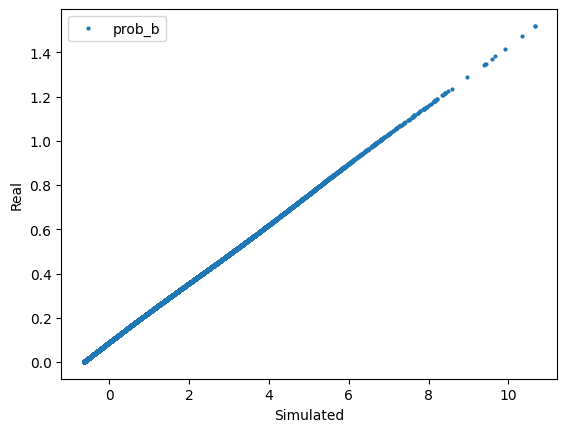

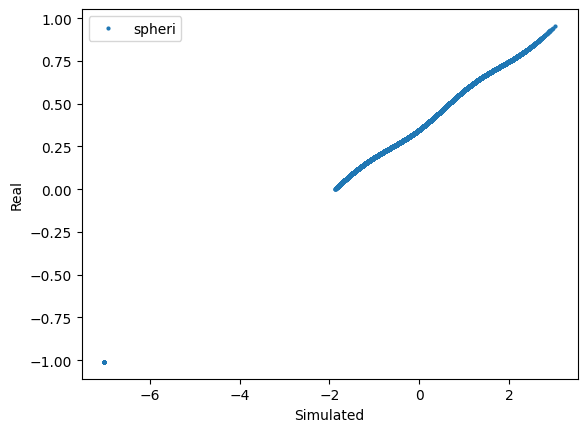

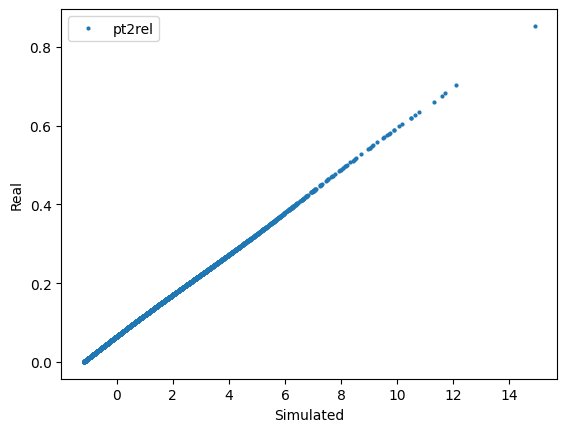

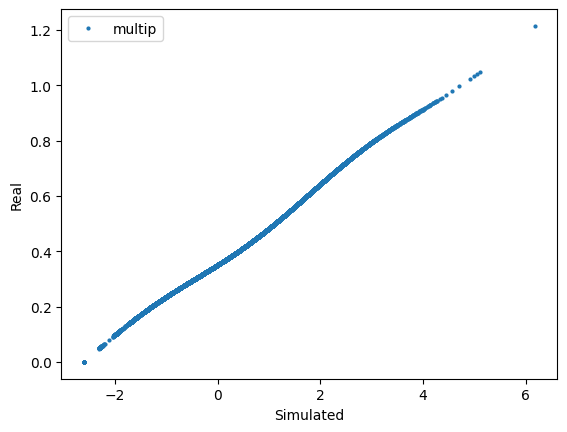

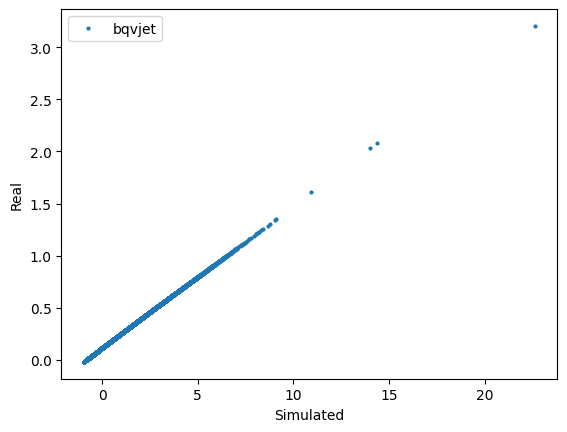

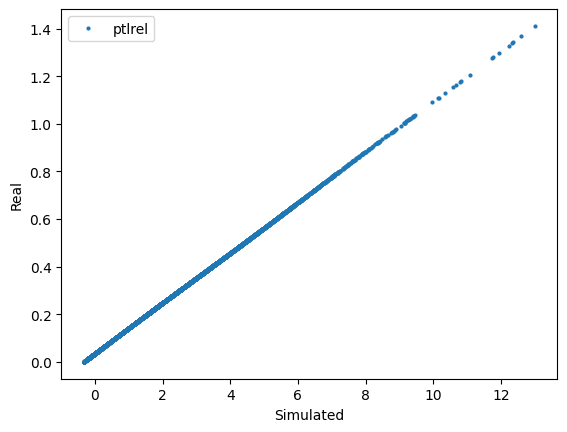


Noise when t=17.



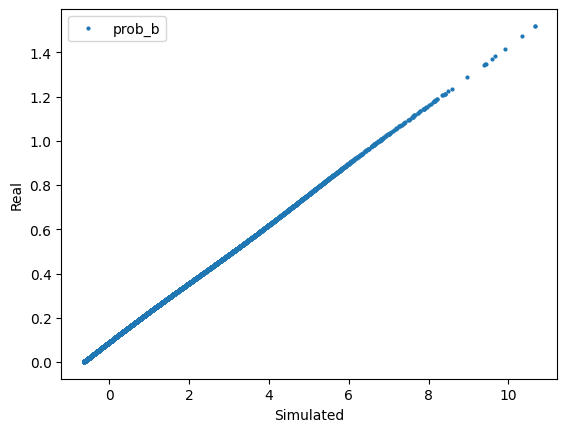

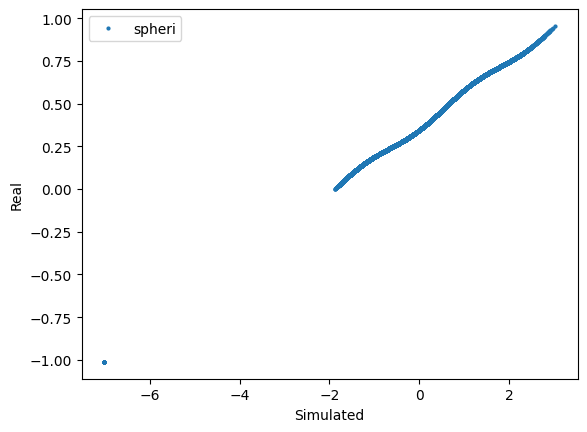

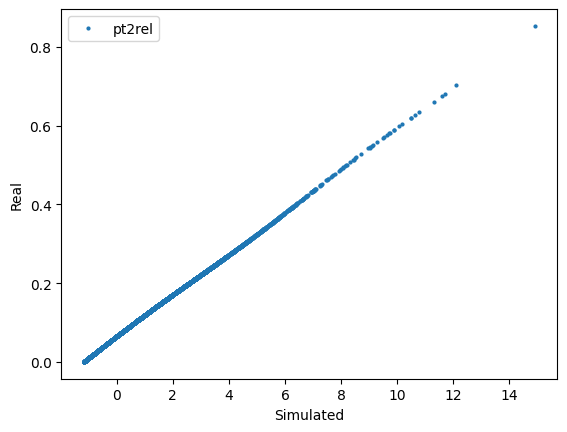

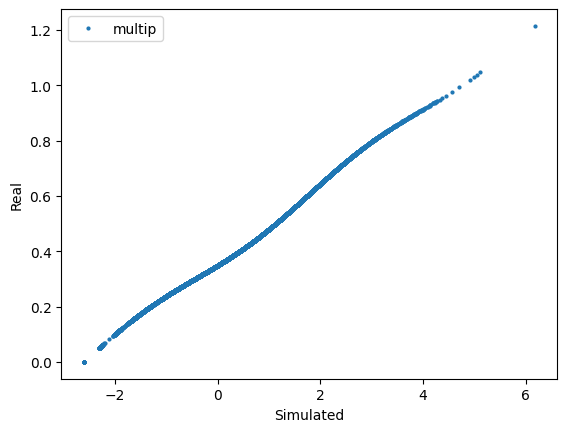

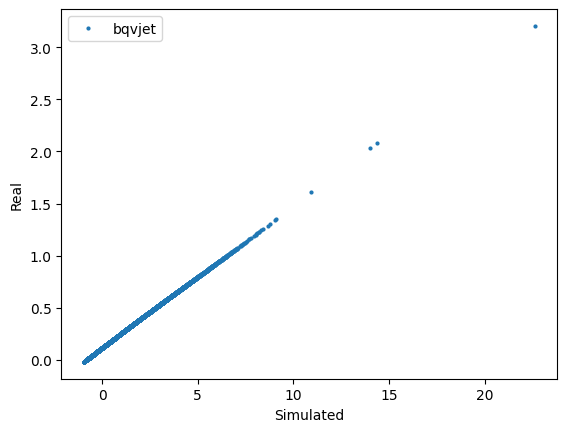

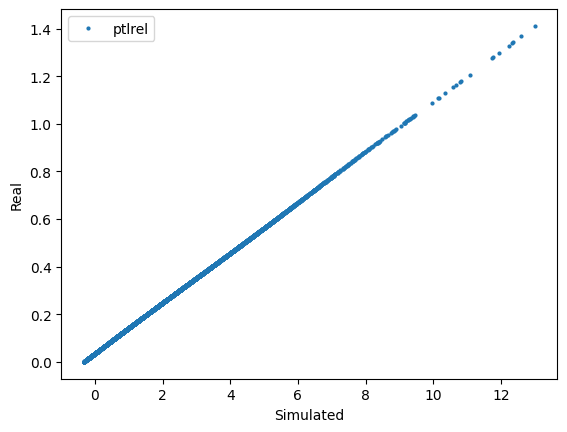


Noise when t=15.



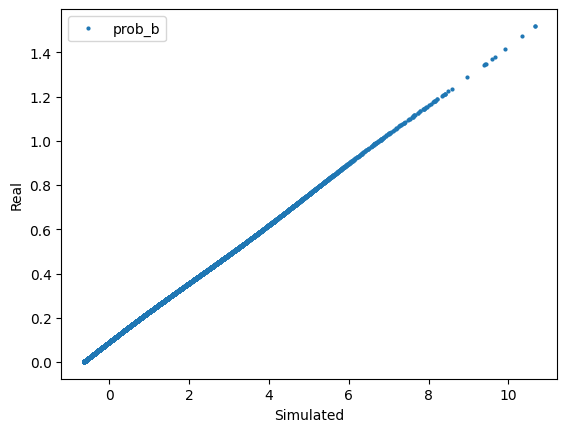

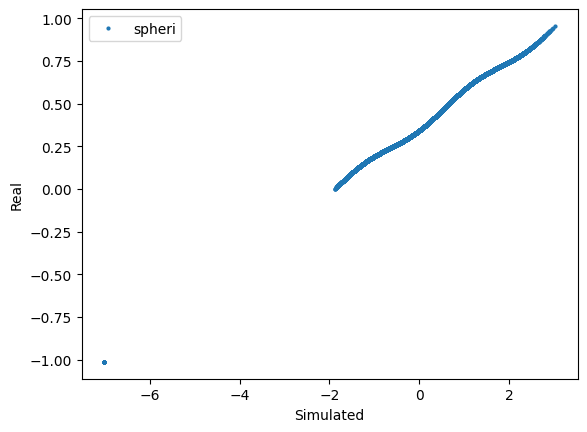

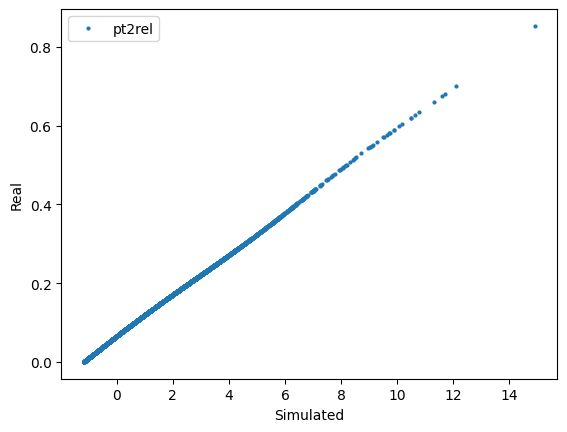

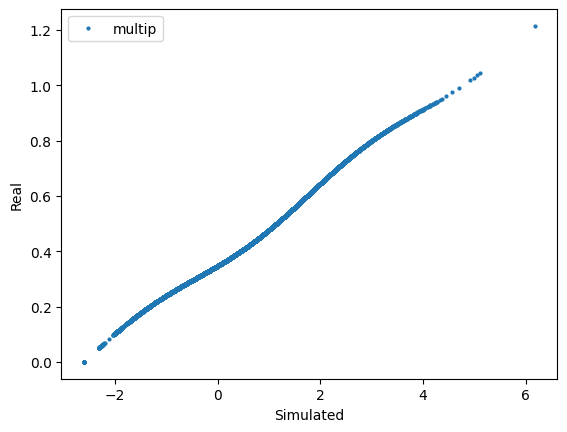

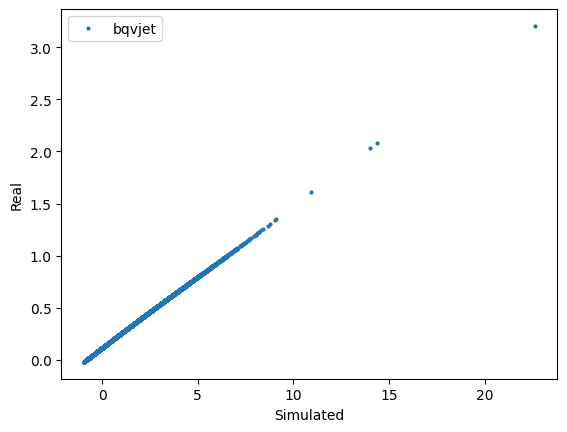

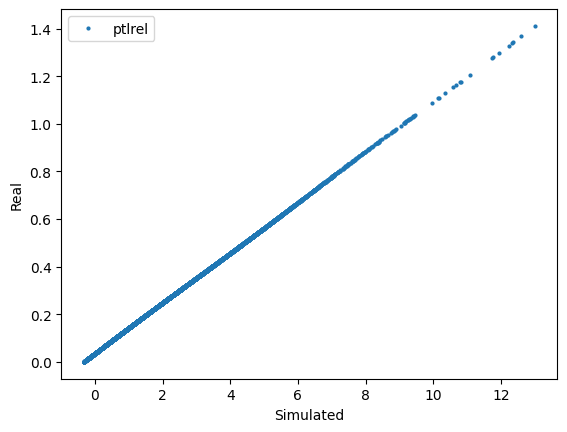


Noise when t=12.



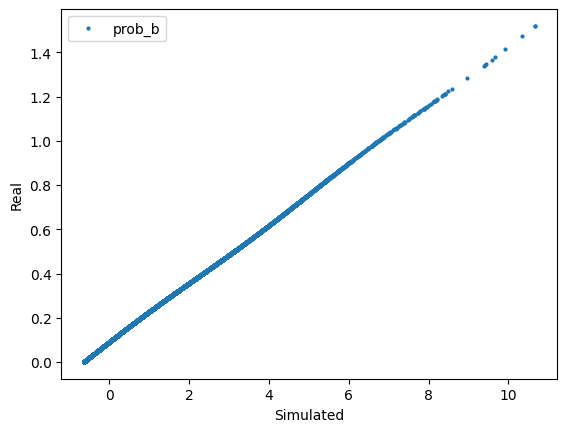

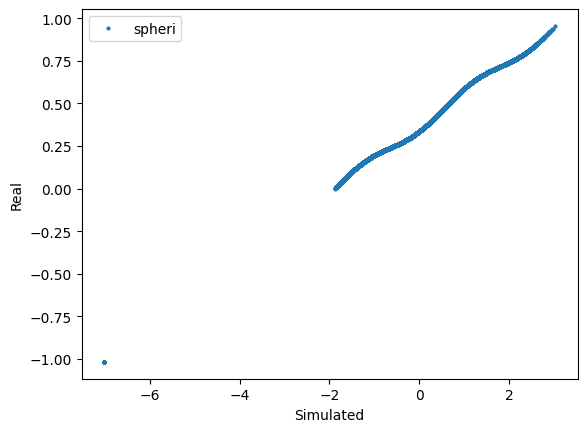

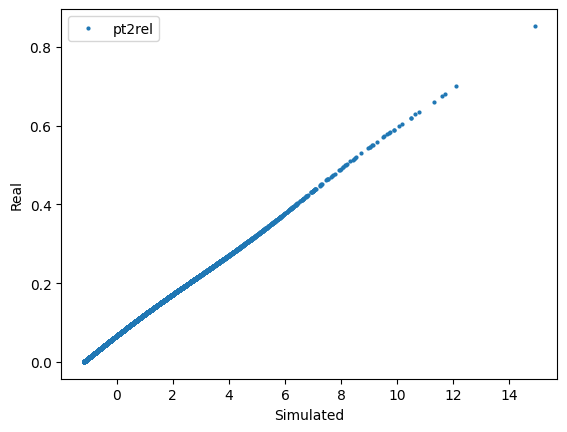

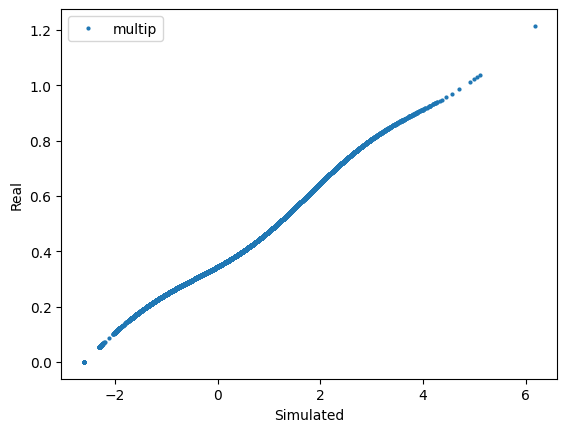

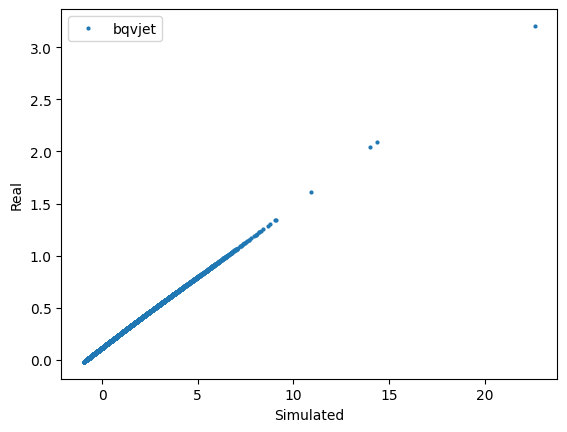

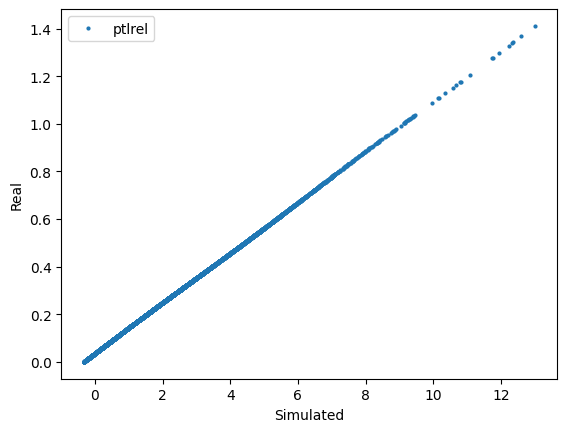


Noise when t=10.



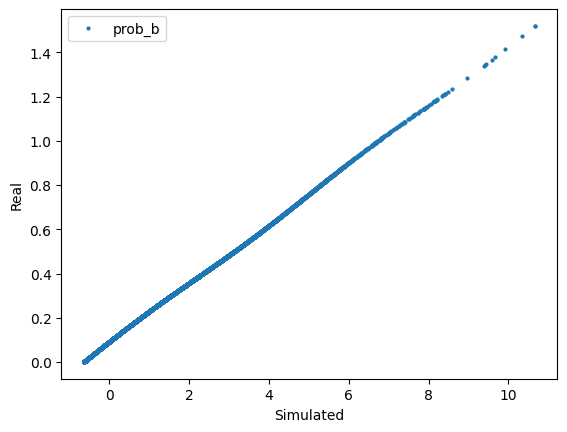

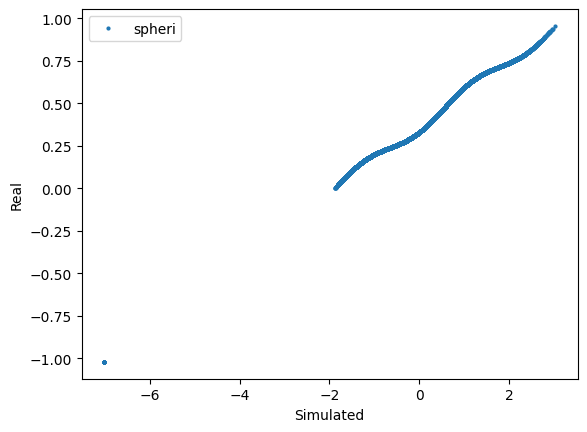

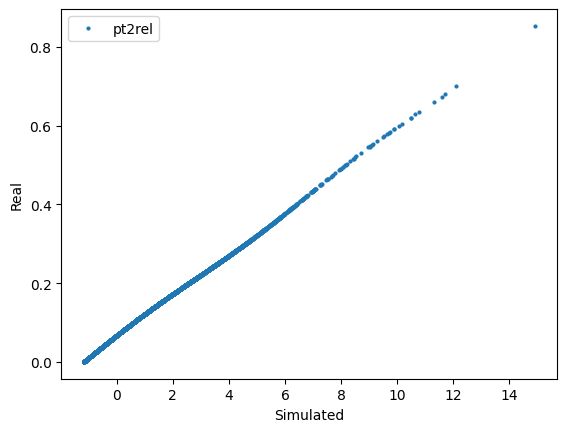

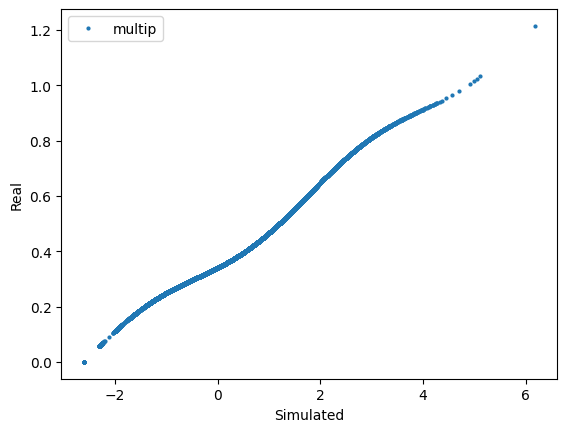

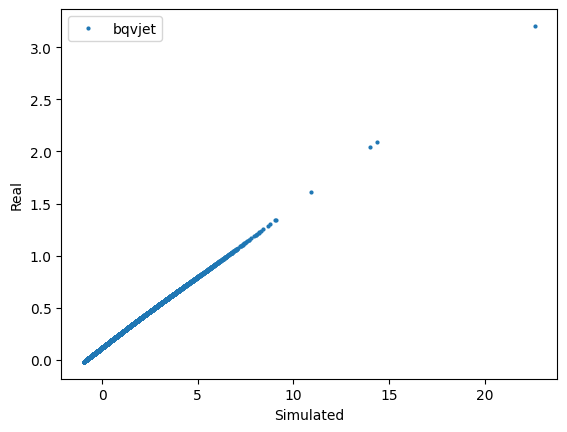

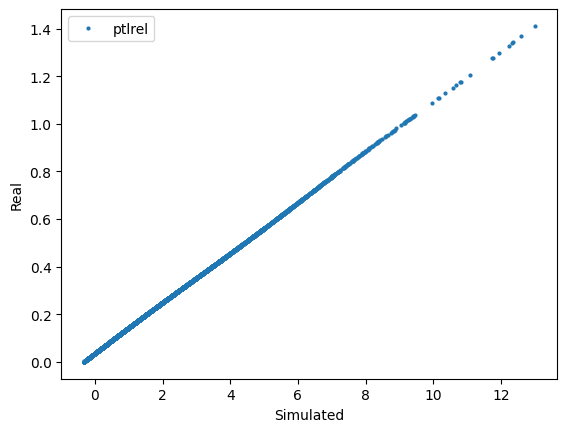


Noise when t=8.



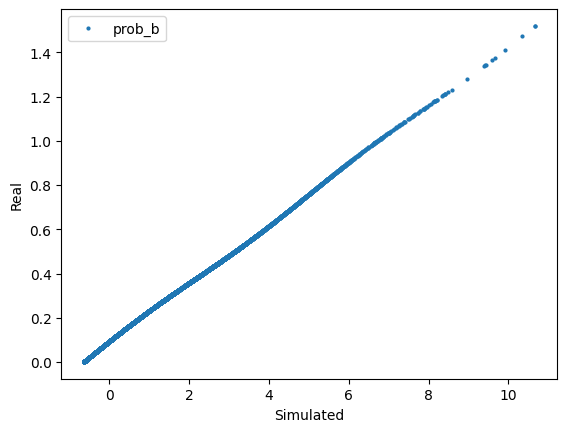

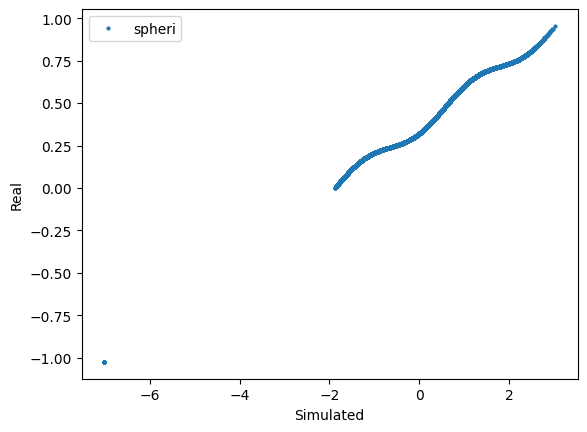

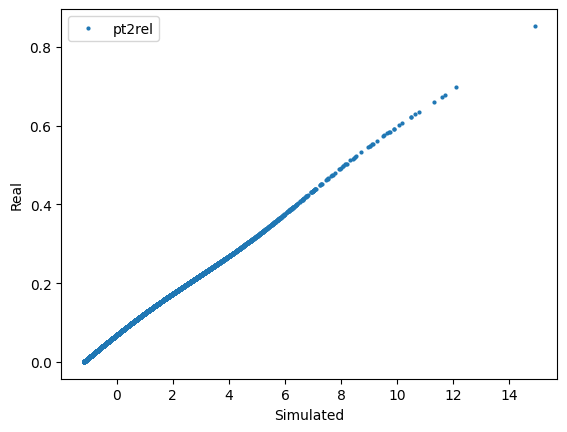

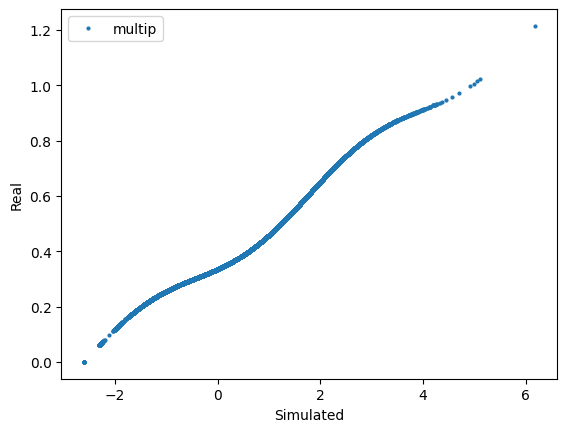

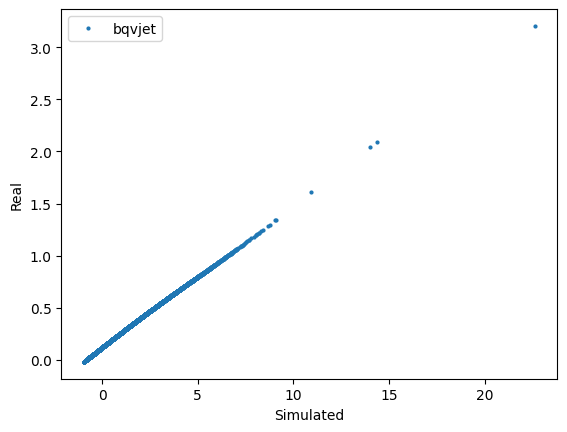

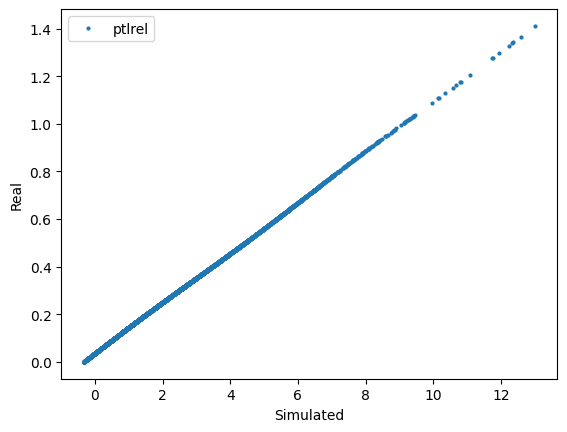


Noise when t=5.



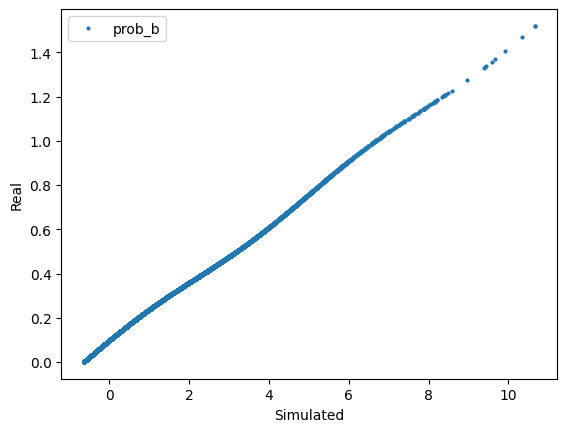

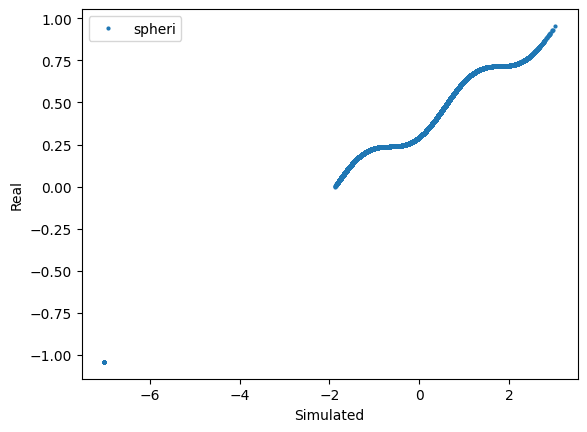

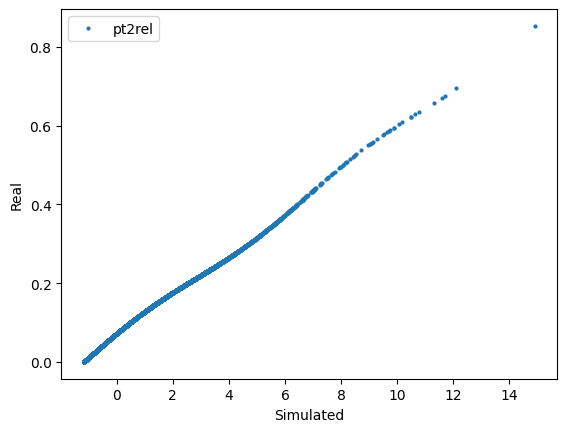

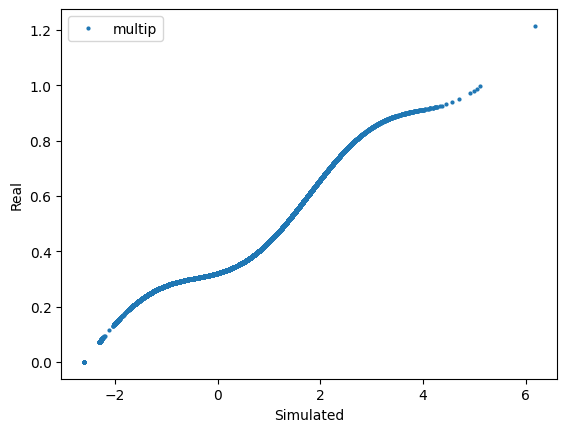

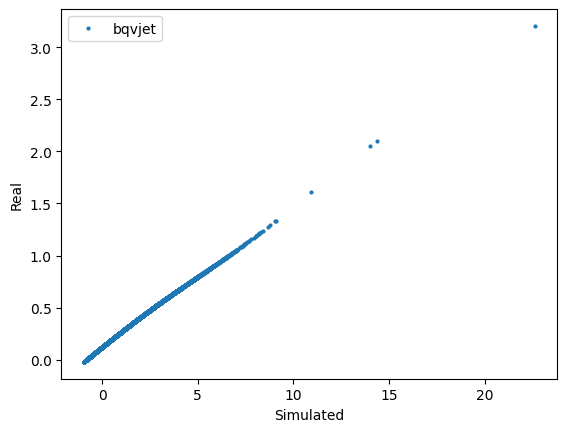

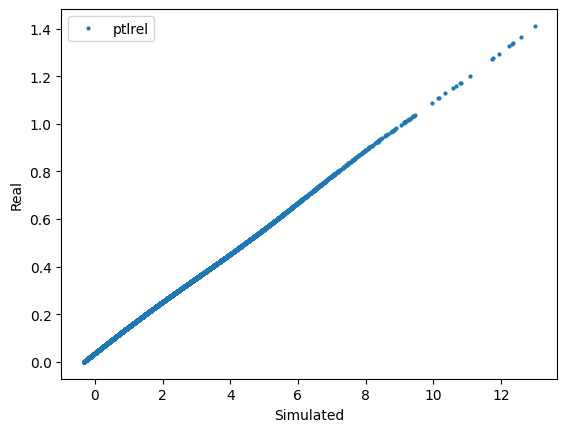


Noise when t=3.



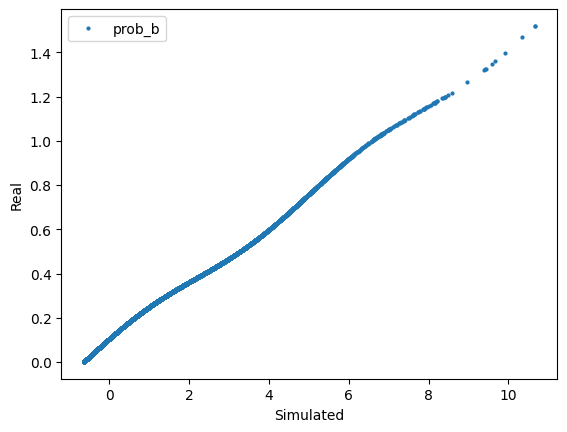

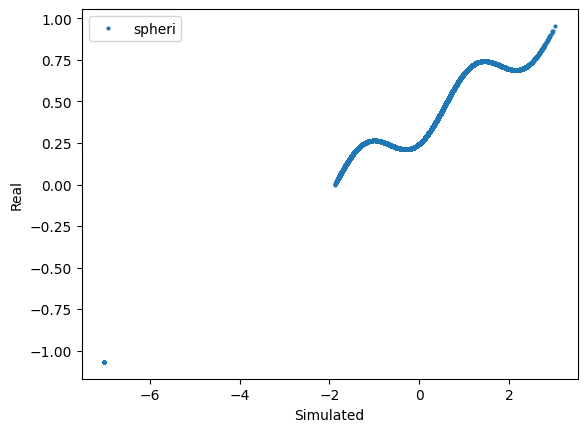

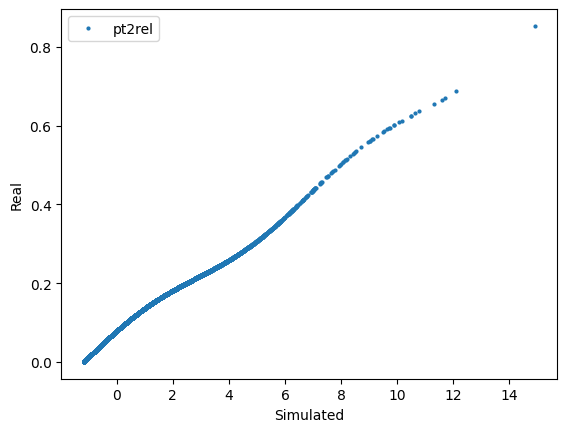

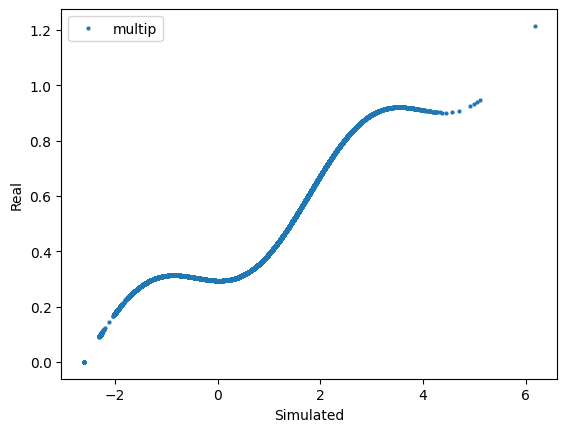

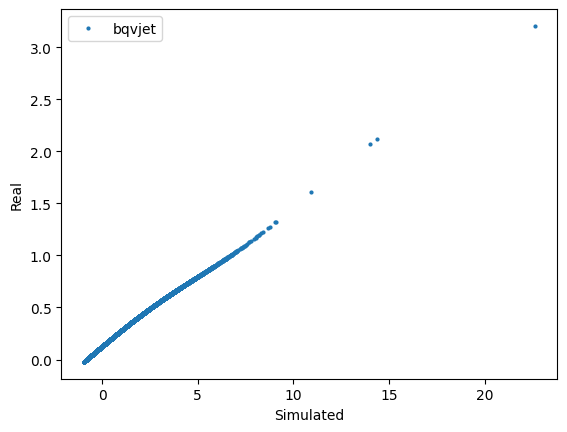

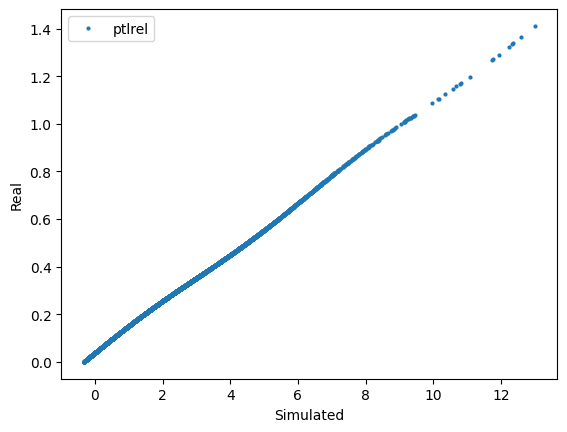


Noise when t=2.5.



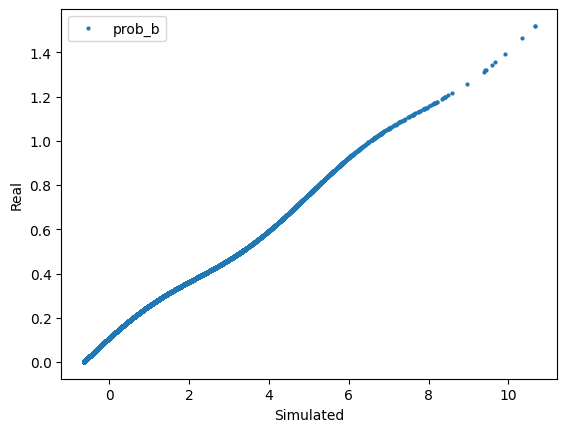

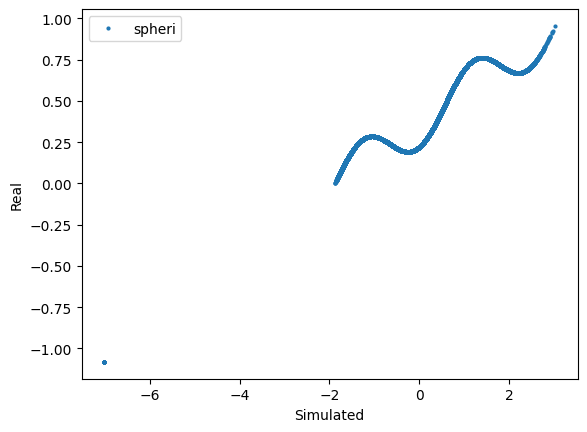

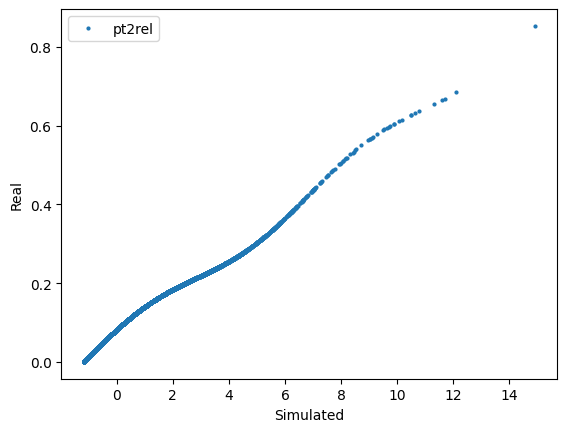

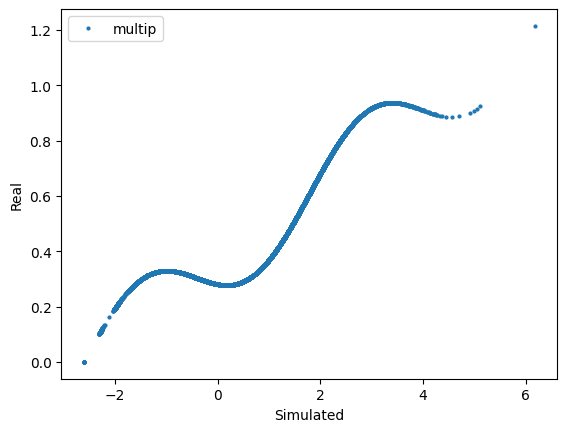

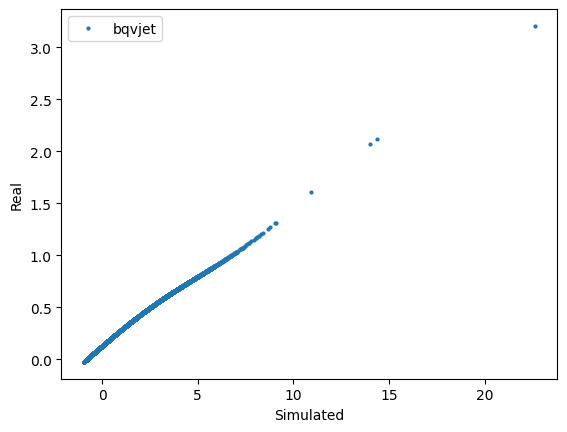

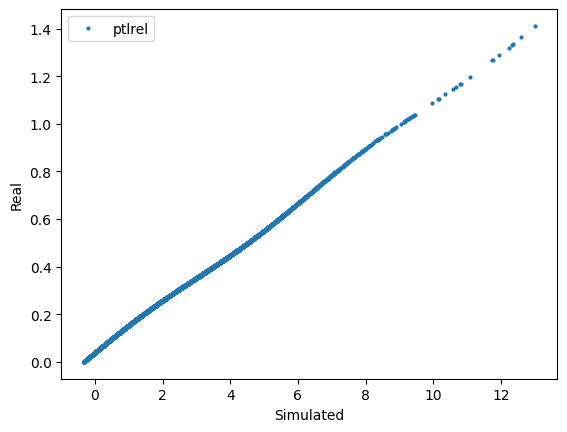


Noise when t=2.



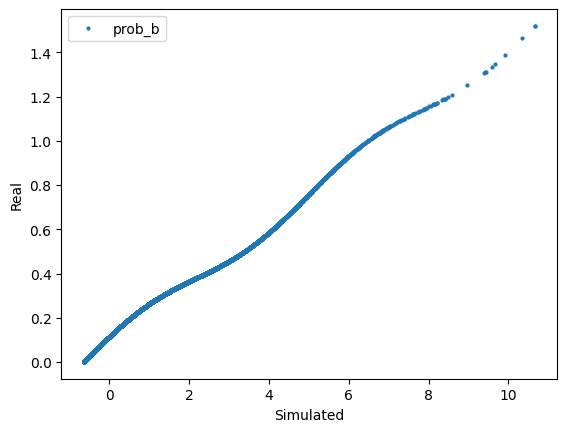

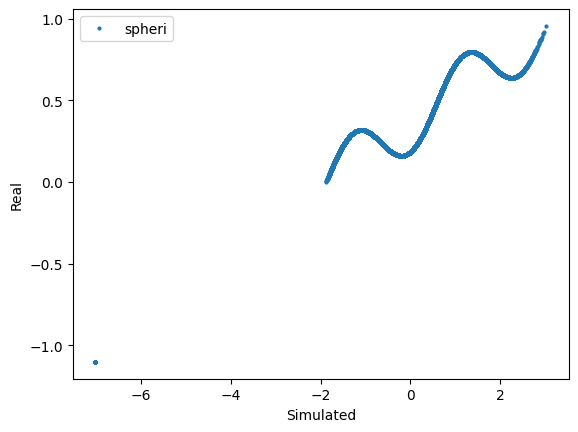

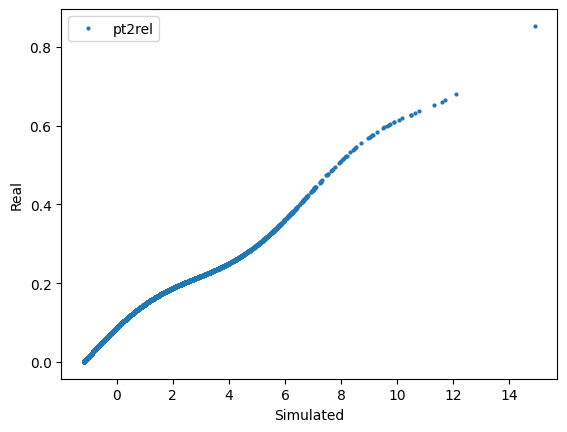

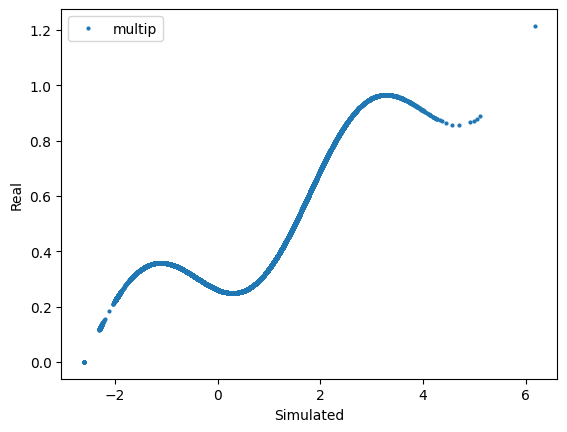

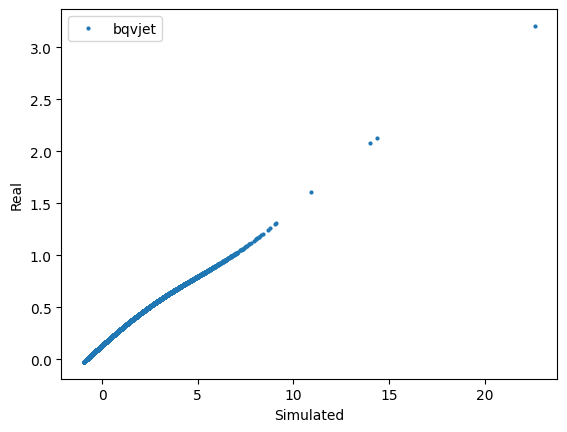

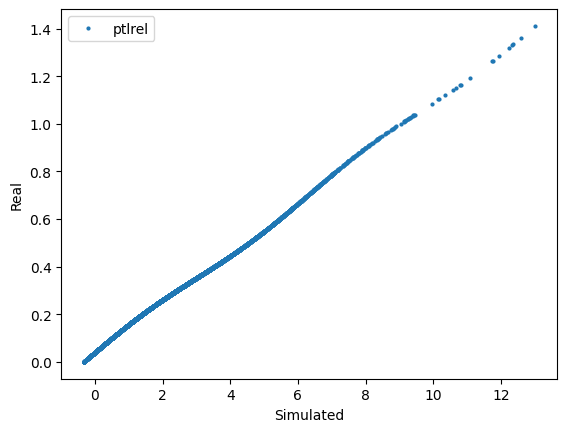


Noise when t=1.75.



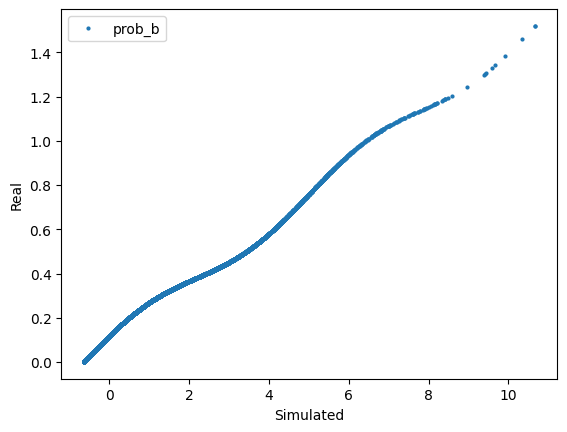

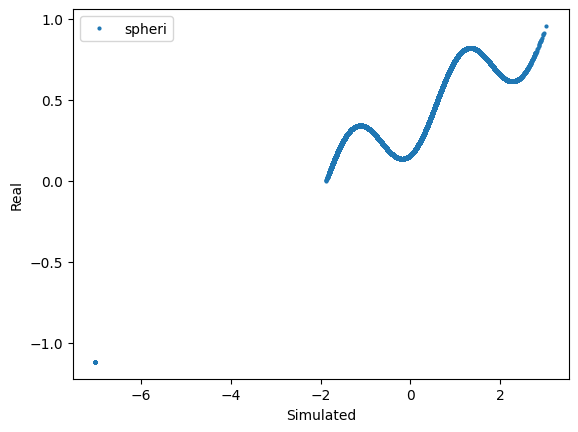

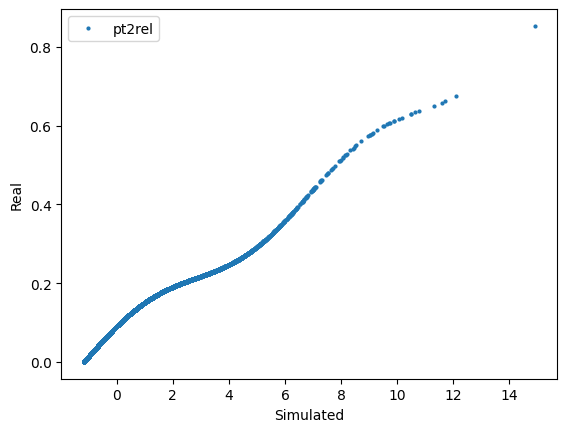

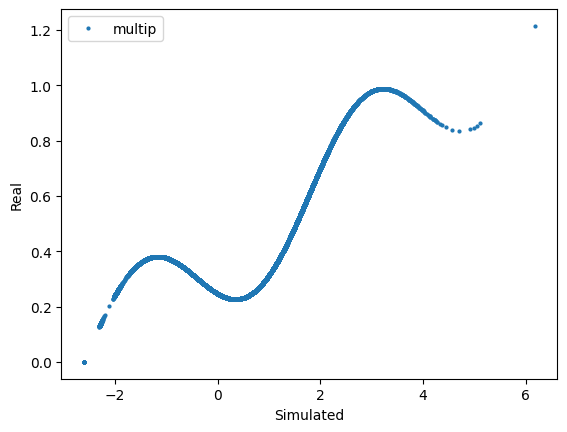

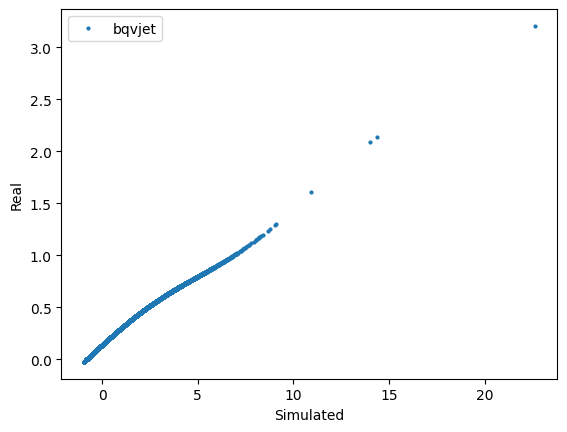

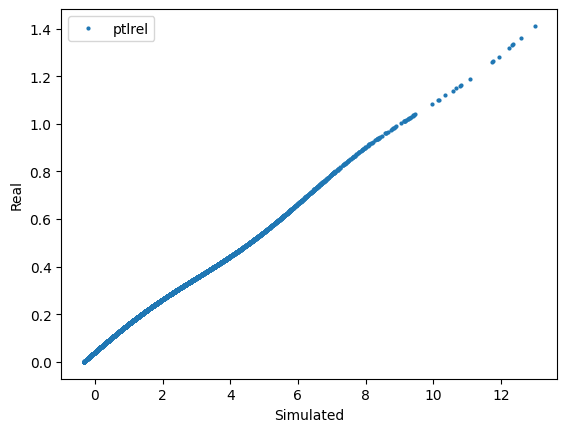


Noise when t=1.5.



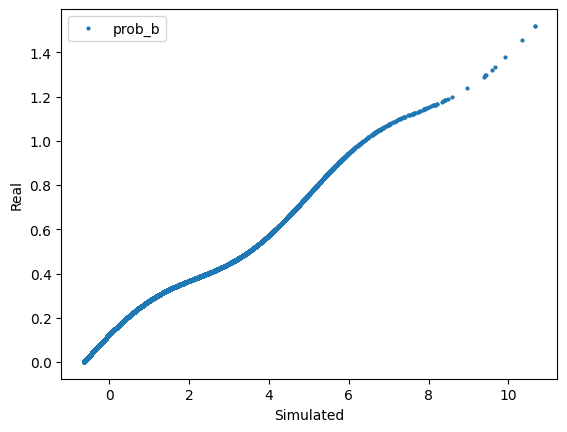

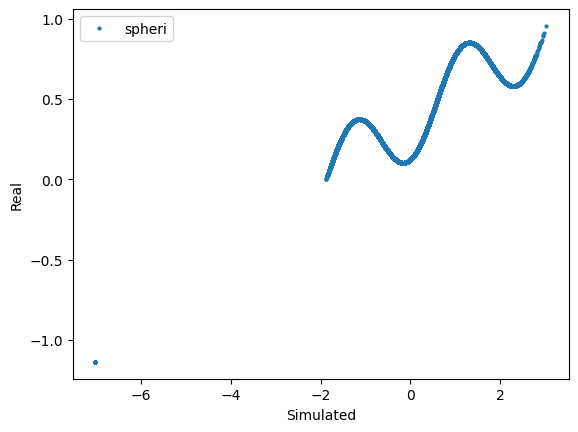

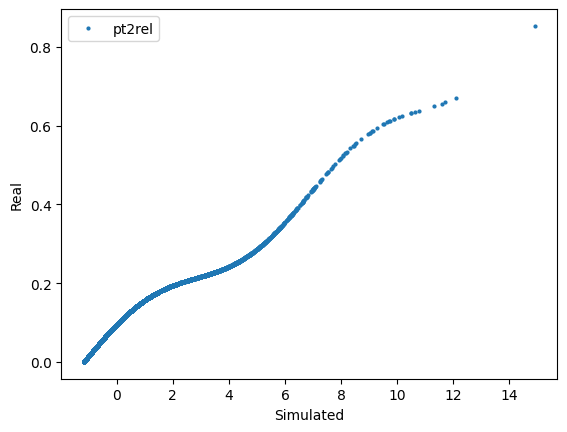

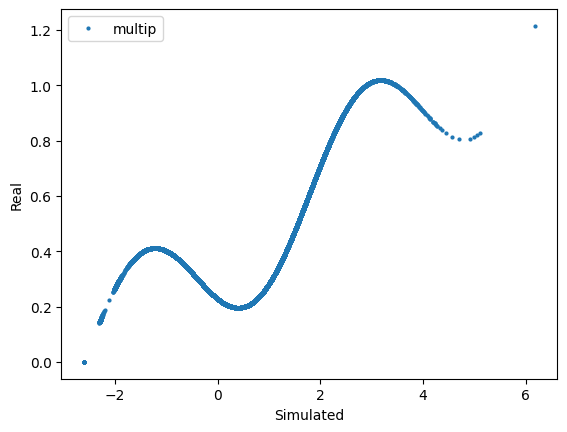

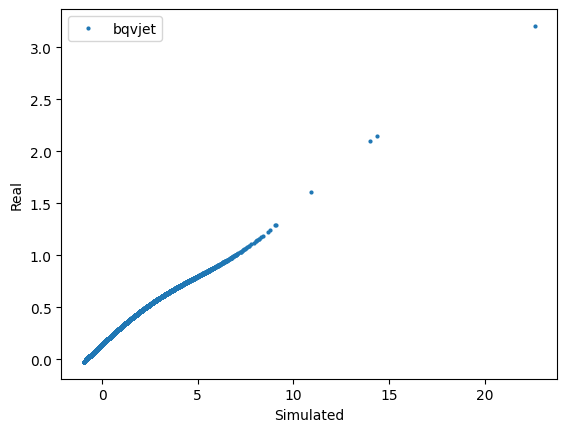

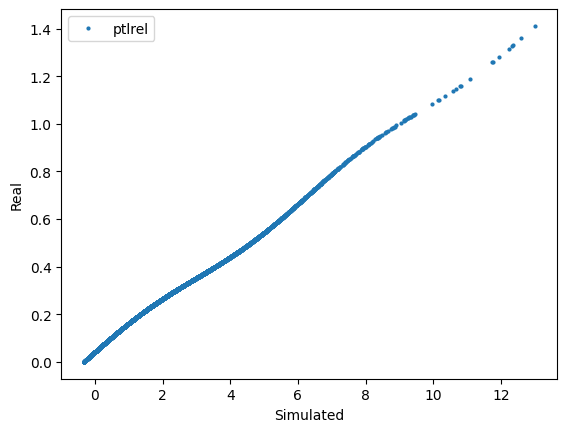


Noise when t=1.25.



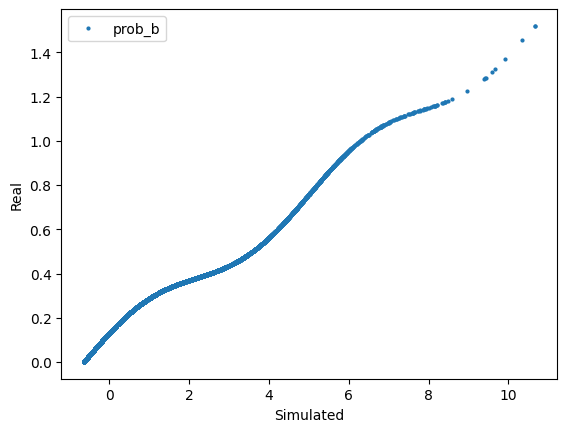

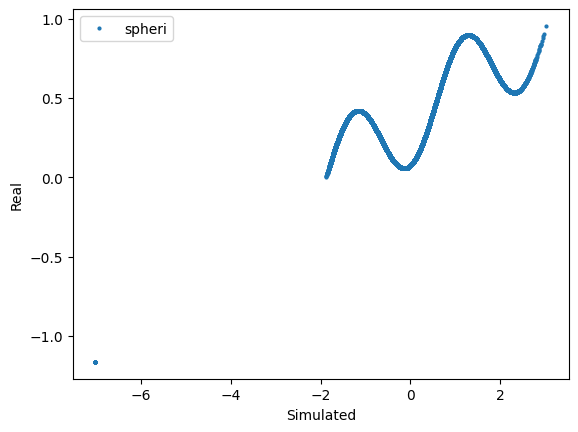

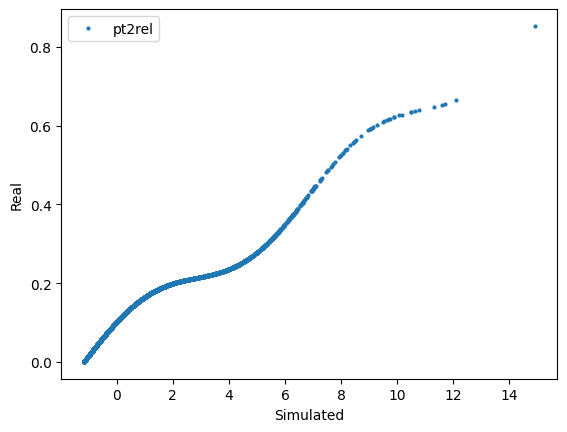

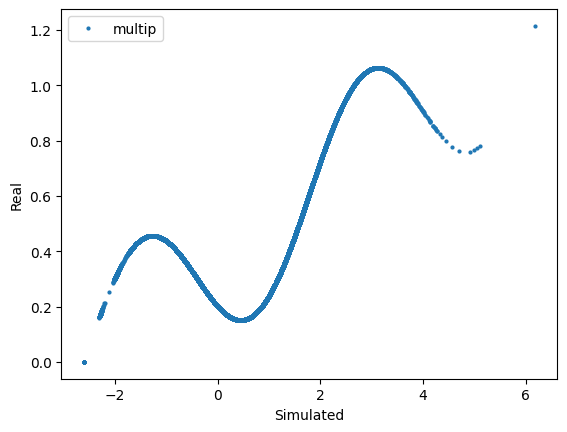

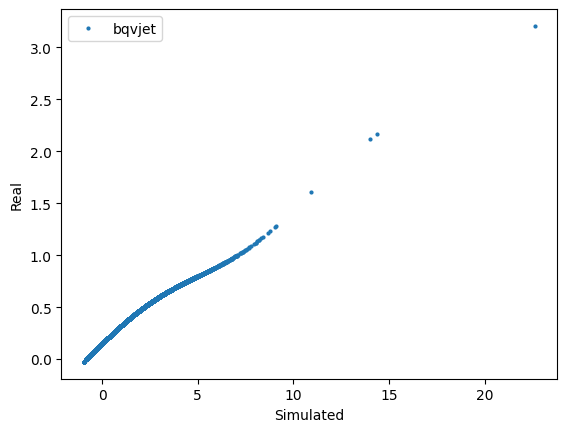

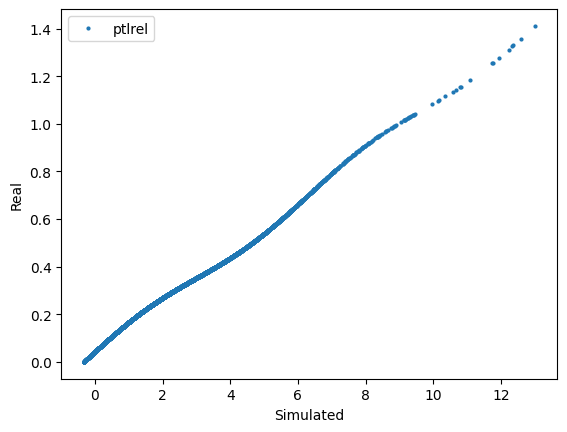


Noise when t=1.



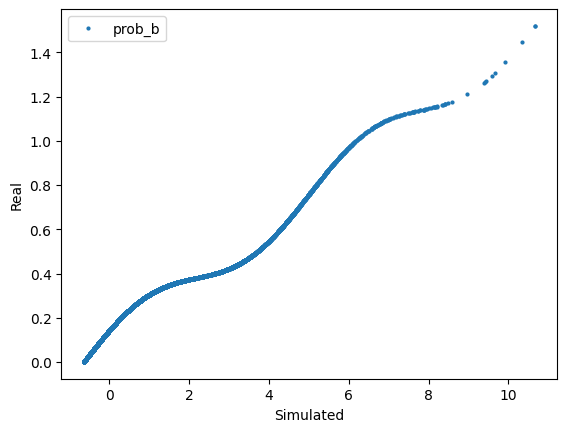

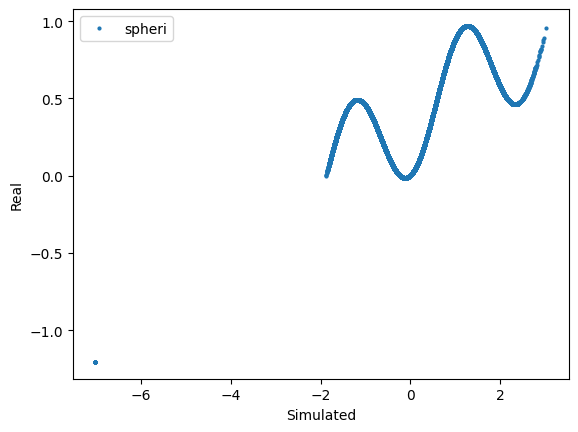

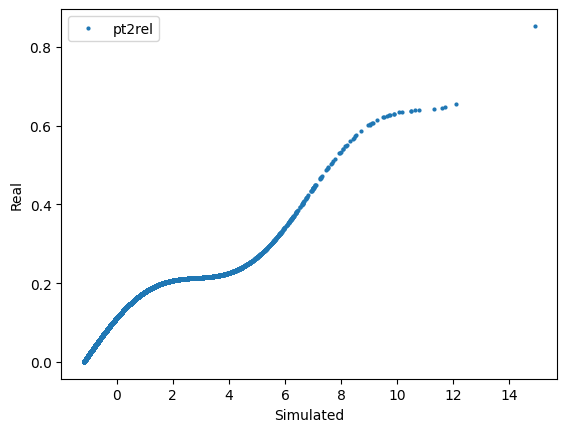

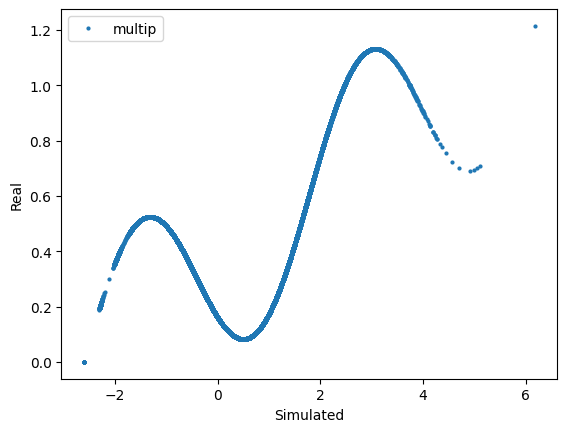

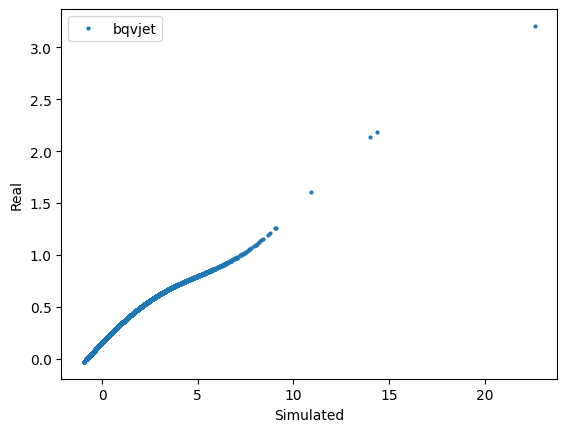

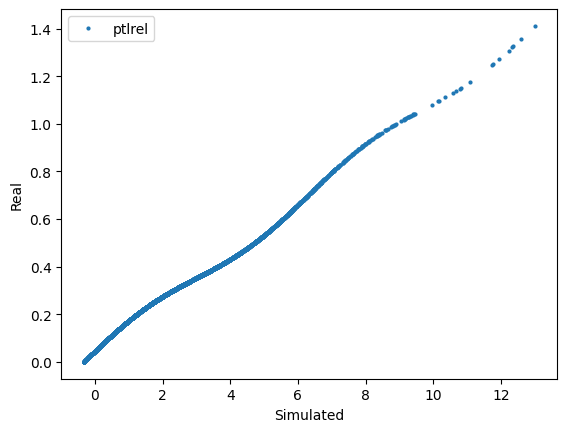


Noise when t=0.8.



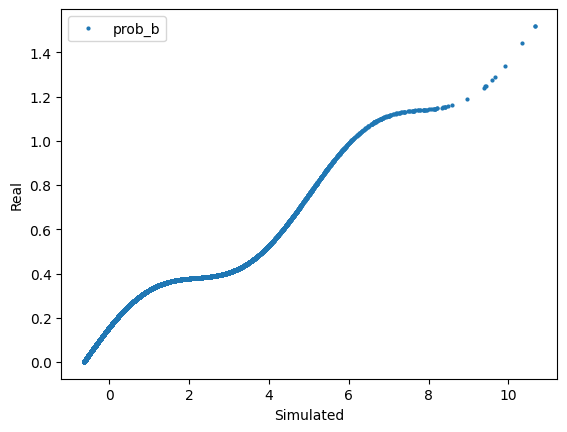

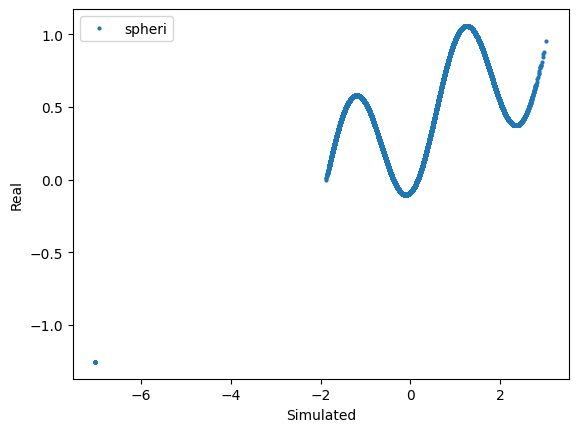

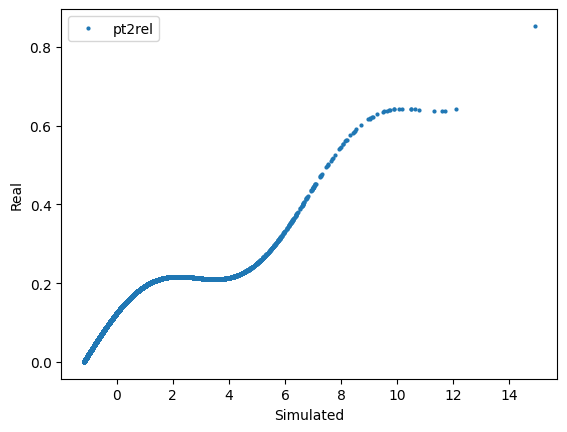

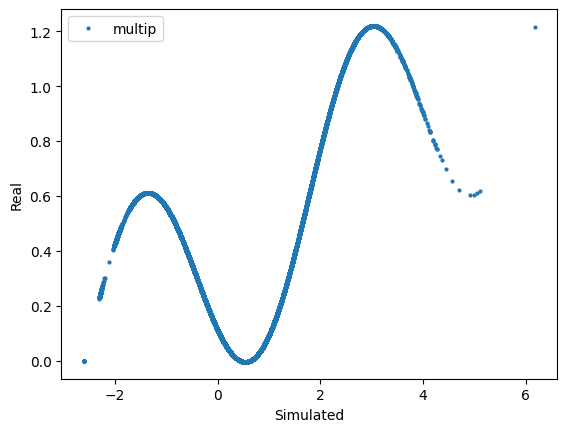

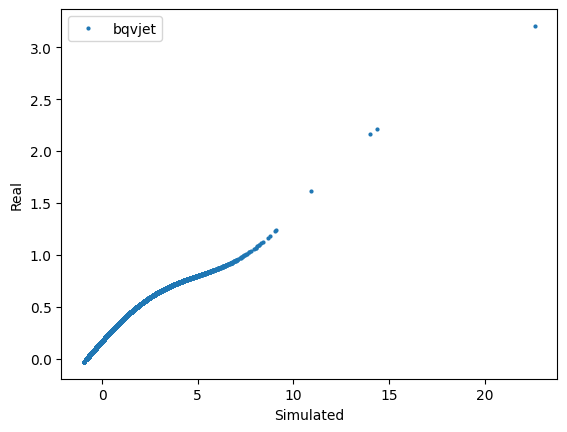

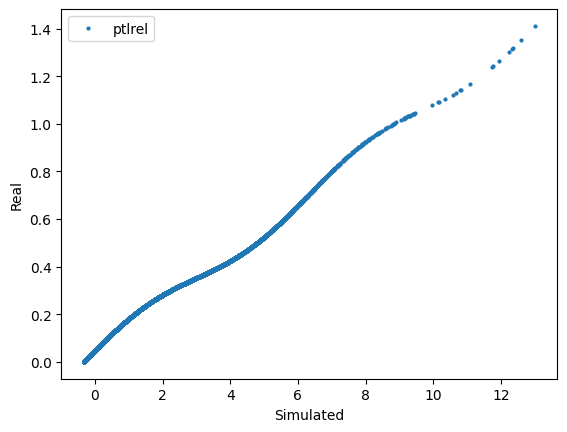


Noise when t=0.7.



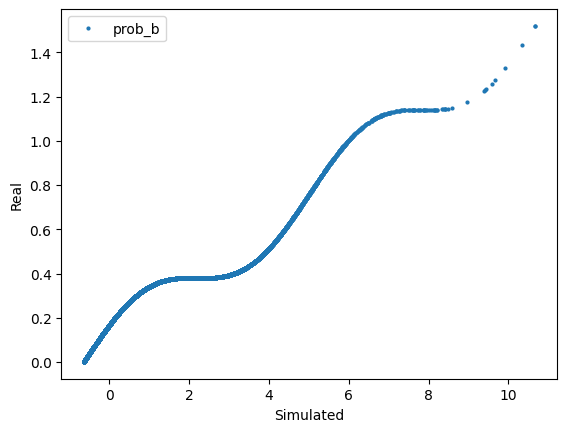

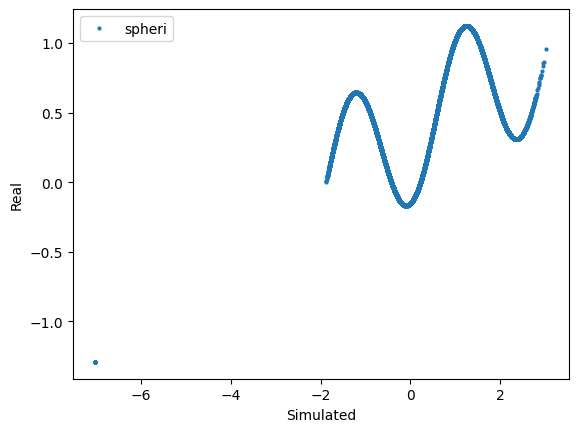

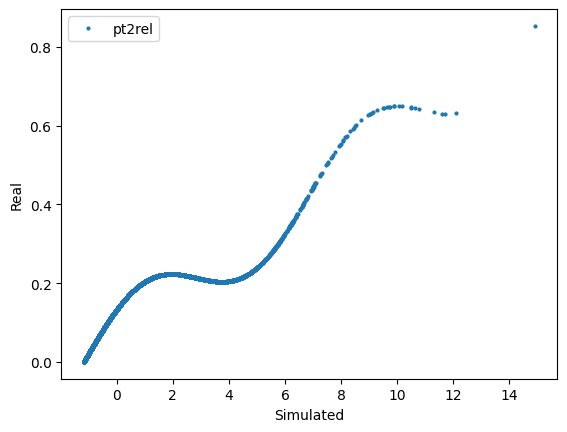

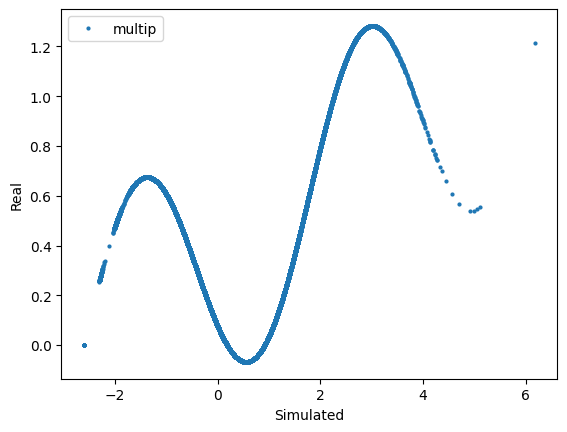

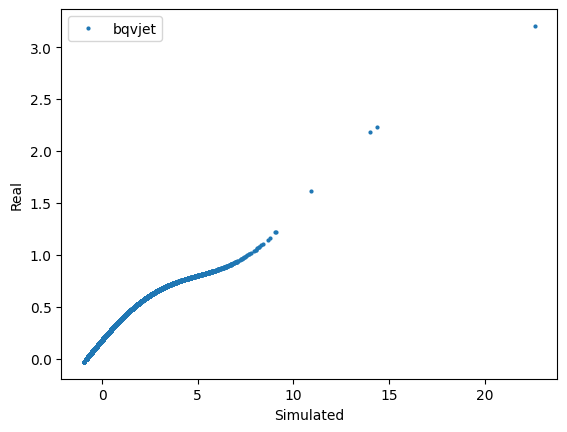

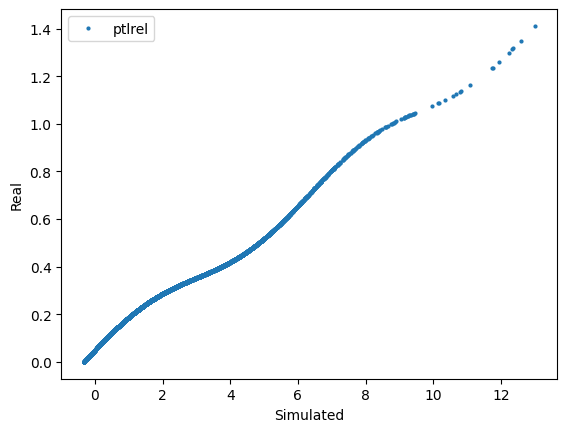


Noise when t=0.6.



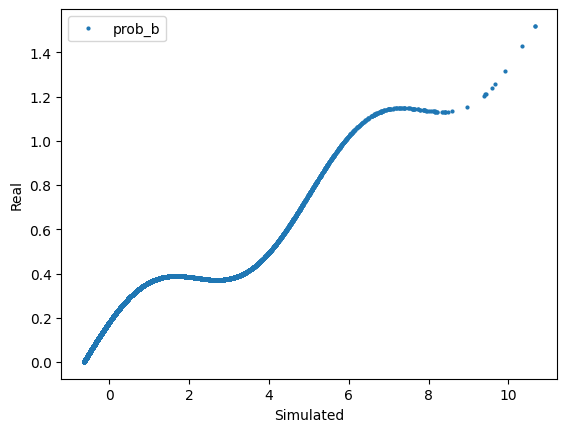

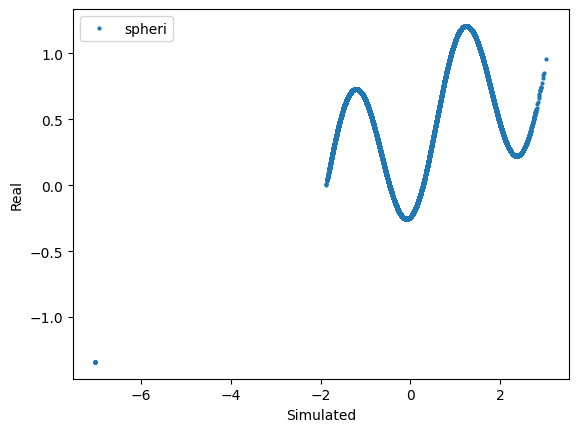

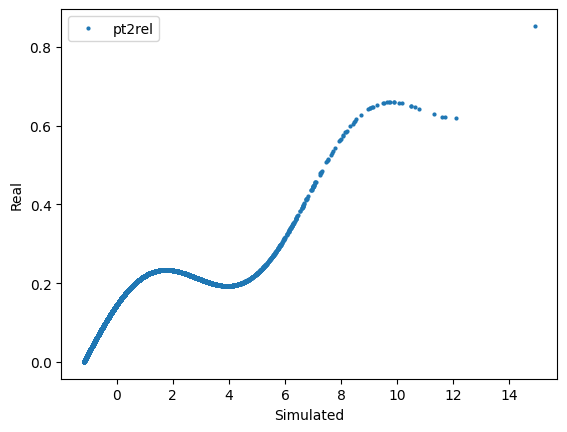

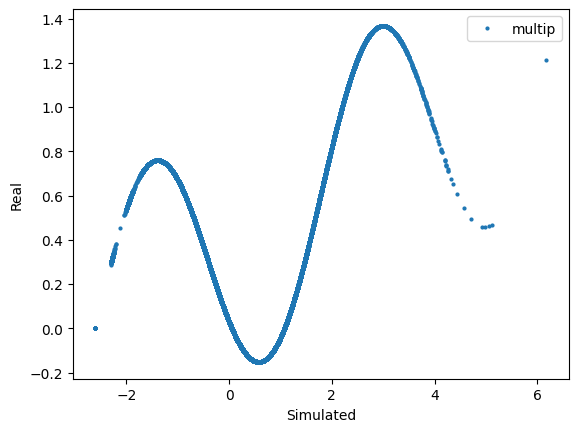

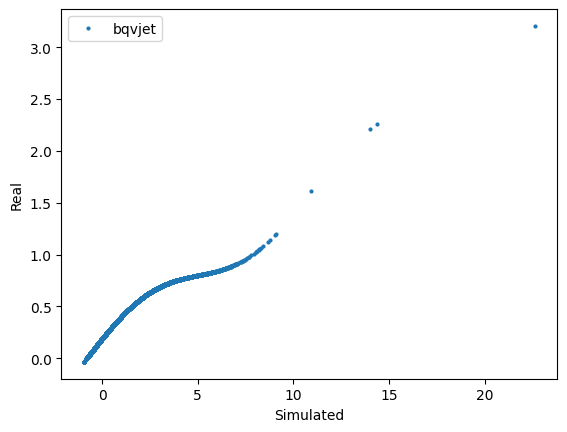

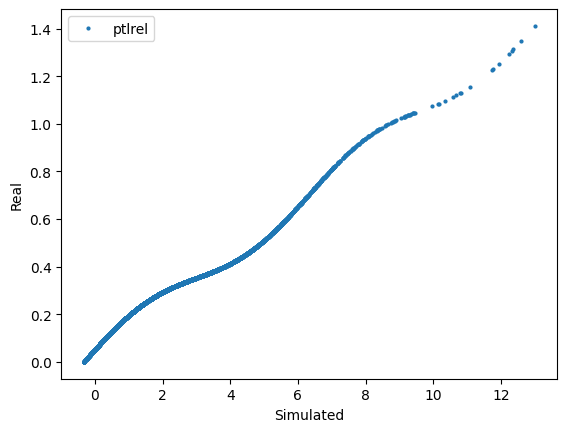

In [8]:
for i, X_noised in enumerate(lo_X_noised_unscaled):
    t = t_range[i]
    print(f"\nNoise when t={t}.\n")
    noise_tester(X_valid, X_noised, histogram=False)

# Build the neural network(s)

In [11]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()

        # Main task output layer
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, int(hidden_dim/2))
        #self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(int(hidden_dim/2), output_dim)

    def forward(self, x):
        hidden = self.relu(self.fc1(x))
        hidden = self.relu(self.fc2(hidden))

        # Main task output
        hidden = self.relu(self.fc3(hidden))
        hidden = self.relu(self.fc4(hidden))
        #hidden = self.relu(self.fc3(hidden))
        main_output = self.fc5(hidden)

        return main_output

# Training helper functions

These will be used in the training loop.

In [12]:
_="""
make_batches(X_tensor, y_tensor, num_batches, batch_size)
OUTPUTS -> List of X batches. List of y batches. (Tensors.)

################################################################################################################################

train_one_epoch(model, loss_fn, optimizer, X_batch_list, y_batch_list, epoch=1, num_epochs=1)
INPUTS -> Model to train. !!! Could be a source of error!
INPUTS -> model, loss function, optimizer. Lists of predictor and target batches. 
INPUTS -> Optional: Current epoch and number of total epochs, for print statement.
OUTPUTS -> Average loss over batches during training.

################################################################################################################################

validate_one_epoch(model, loss_fn, X_valids, y_valids)

OUTPUTS -> Validation loss. (No batches in validation yet.)
################################################################################################################################

train_model(model, t_X_train, t_y_train, t_X_valid, t_y_valid, num_epochs=num_epochs, 
               batch_size=batch_size, num_batches=num_batches, freq=freq, eps=eps)
INPUT -> freq: How often to validate and save losses.
         eps : For optimizer.
OUTPUT -> trained_model, train_loss_list, valid_loss_list
"""

# Optimizer, loss-fcn. and training parameters

In [13]:
# Parameters for MLP network.
input_dim = t_X_train.shape[1]
hidden_dim = 10
output_dim = 1

# Parameters for the training loop.
eps = 2  # For optimizer.
freq = 5 # How often to do validation loss calculations.
num_epochs = 250
batch_size = 50000
num_batches = np.ceil(t_X_train.shape[0]/batch_size).astype(int)
print(f"Number of batches: {num_batches}")

# Loss and optimizer.
def loss_function():
    return nn.BCEWithLogitsLoss()

def optimizer_function(model, eps, num_epochs): # Added weight_decay for L2 regularization
    optimizer = optim.Adam(model.parameters(), lr= eps*(10**(-3)), weight_decay=eps*(10**(-3))/num_epochs)
    return optimizer

Number of batches: 7


# Train the model

**NOTE: This only runs on GPU, because model and tensors were sent to GPU.**

In [14]:
# Instantiate the NN model.
model = MLP(input_dim, hidden_dim, output_dim).cuda()
# Instantiate loss function and optimizer.
loss_fn = loss_function()
optimizer = optimizer_function(model, eps, num_epochs)

model, train_loss_list, valid_loss_list = train_model(model, t_X_train, t_y_train, t_X_valid, t_y_valid,
                                                      loss_fn, optimizer, num_epochs=num_epochs, 
                                                      batch_size=batch_size, num_batches=num_batches, freq=freq, eps=eps)

Epoch number: 0
Epoch number: 1
Epoch number: 2
Epoch number: 3
Epoch number: 4
Epoch number: 5
Epoch number: 6
Epoch number: 7
Epoch number: 8
Epoch number: 9
Epoch number: 10
Epoch number: 11
Epoch number: 12
Epoch number: 13
Epoch number: 14
Epoch number: 15
Epoch number: 16
Epoch number: 17
Epoch number: 18
Epoch number: 19
Epoch number: 20
Epoch number: 21
Epoch number: 22
Epoch number: 23
Epoch number: 24
Epoch number: 25
Epoch number: 26
Epoch number: 27
Epoch number: 28
Epoch number: 29
Epoch number: 30
Epoch number: 31
Epoch number: 32
Epoch number: 33
Epoch number: 34
Epoch number: 35
Epoch number: 36
Epoch number: 37
Epoch number: 38
Epoch number: 39
Epoch number: 40
Epoch number: 41
Epoch number: 42
Epoch number: 43
Epoch number: 44
Epoch number: 45
Epoch number: 46
Epoch number: 47
Epoch number: 48
Epoch number: 49
Epoch number: 50
Epoch number: 51
Epoch number: 52
Epoch number: 53
Epoch number: 54
Epoch number: 55
Epoch number: 56
Epoch number: 57
Epoch number: 58
Epoch n

# Make plots

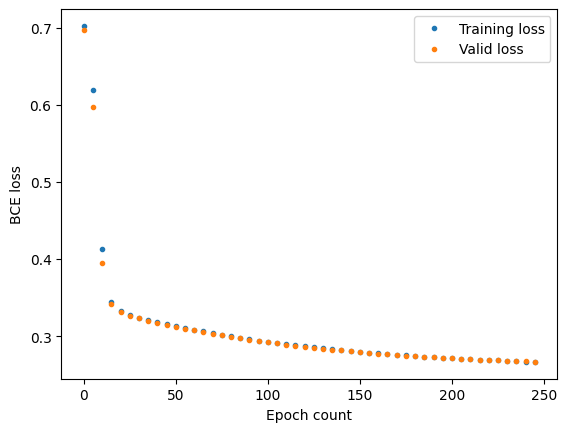

In [15]:
"""
plot_training_losses(freq=freq, train_loss=train_loss_list, valid_loss=valid_loss_list, losstype='BCE loss')
RETURNS-> Nothing. Plots train and validation losses from training.
"""
plot_training_losses(freq=freq, train_loss=train_loss_list, valid_loss=valid_loss_list, losstype='BCE loss')

# Accuracy on test set

Let's see if we can make predictions.

In [16]:
"""
clf_accuracy(model, X_test, y_test)
RETURNS -> Nothing. Prints accuracy.
"""

clf_accuracy(model=model, X_test=t_X_valid, y_test=t_y_valid)

Accuracy: 90.11%


# Consistency

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score

In [18]:
def consistency(X,y,k=10):
    """
    INPUTS
    X: Predictor dataframe.
    y: Predictions from MLP/DANN.
    k: Number of nearest neighbors to consider.
    OUTPUT: Consistency score, ranging from 0 (bad) to 1 (good).
    """
    X_numpy   = X.cpu().numpy()
    y_numpy   = y.cpu().numpy()
    neigh     = NearestNeighbors(n_neighbors=k).fit(X_numpy)
    ind_neigh = neigh.kneighbors(X_numpy, return_distance=False)
    
    consistency_list = []
    for i, y_i in enumerate(y_numpy):
        y_neighbors = y_numpy[ind_neigh[i]]
        
        # Below is the main consistency equation.
        
        consistency_i = np.abs( y_i - 1/k * np.sum(y_neighbors) )
        consistency_list.append(consistency_i)
        
    consistency_value = 1 - 1/len(y) * np.sum(consistency_list)
    return consistency_value

In [19]:
k = 8 # Number of voting nearest neighbors for consistency.
consistency_list = []
for X_noised in lo_T_noised:
    with torch.no_grad():  # Disable gradient calculation for evaluation
        y_predicted = model(X_noised)
        cons = consistency(X_noised, y_predicted, k=k)
        consistency_list.append(cons)

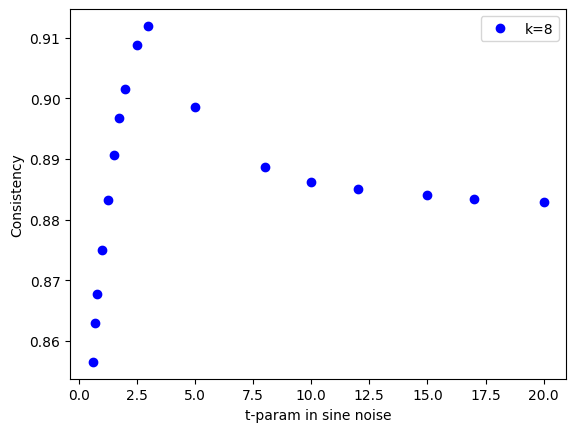

In [23]:
plt.plot(t_range, consistency_list, 'bo', label=f"k={k}")
plt.xlabel("t-param in sine noise")
plt.ylabel("Consistency")
plt.legend()
plt.show()

In [21]:
# make_roc(model, [(192*t_X_test_noised_gaussian, t_y_test_noised_gaussian, 'lmfao')])